In [75]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [76]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Reproduce TTV Result for TIC 100100827

- also known as WASP-18
- TTV first identified in [2019AJ....158..243P](https://ui.adsabs.harvard.edu/abs/2019AJ....158..243P/abstract) based on TESS data sectors 1 -3 . Its figure 15:

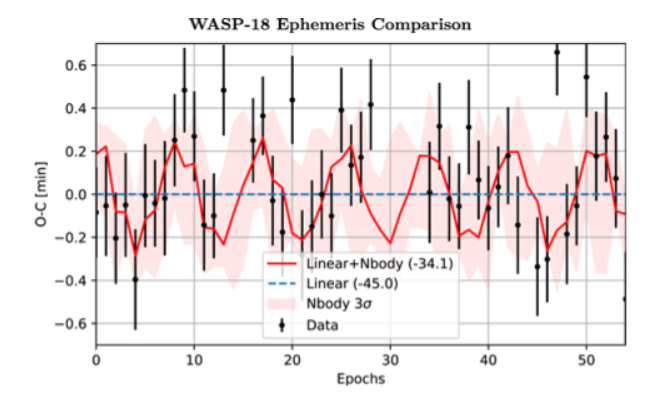

From LcTools:
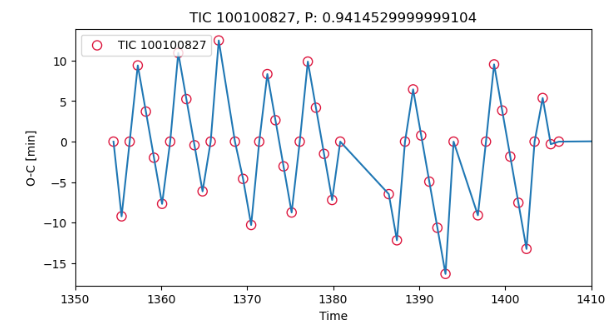



In [77]:
# define the plotting parameters

figsize = (8,4)

In [110]:
# import the data

# choose a TIC ID to analyze
ticid = 100100827  # WASP-18, 2 planets, b's P: 0.94145223 , C'p: 2.1558 

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (sector 5)
sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lc_tess = sr.download_all().stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 02,2018,SPOC,120,100100827,0.0,"G011112 , G011183 , G011132 , G011250"
1,TESS Sector 03,2018,SPOC,120,100100827,0.0,"G011112 , G011183 , G011132 , G011250"
2,TESS Sector 29,2020,SPOC,120,100100827,0.0,"G03232 , G03278 , G03106"
3,TESS Sector 30,2020,SPOC,120,100100827,0.0,"G03232 , G03278 , G03106"
4,TESS Sector 69,2023,SPOC,120,100100827,0.0,"G05095 , G05015 , G05105 , G05098 , G05069 , G05003"


86067

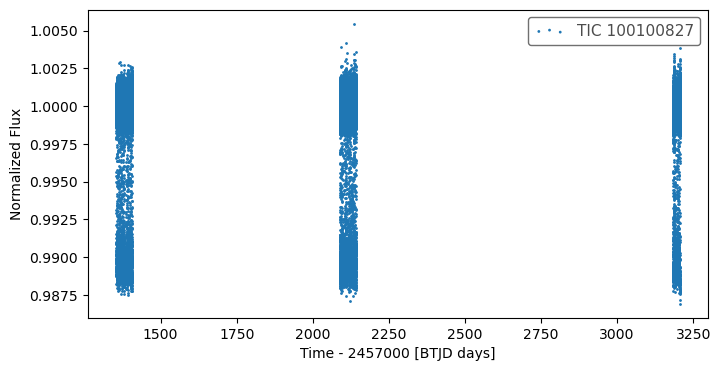

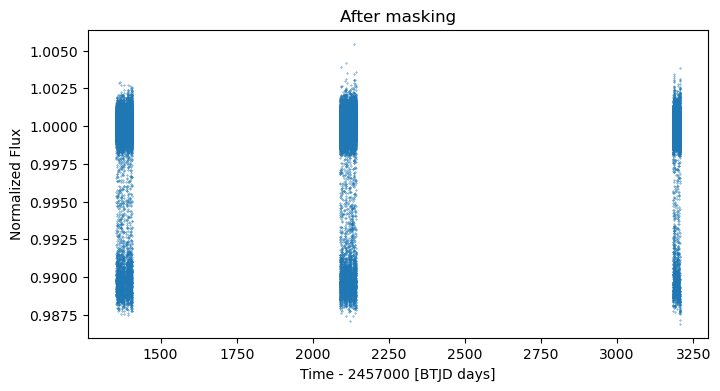

In [111]:
%matplotlib inline
# %matplotlib widget

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)


mask = time < 0 #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [80]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

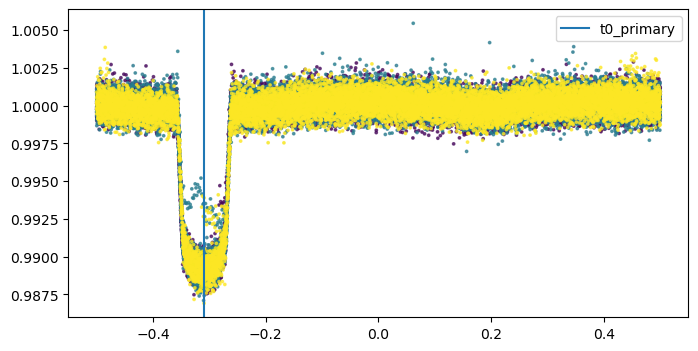

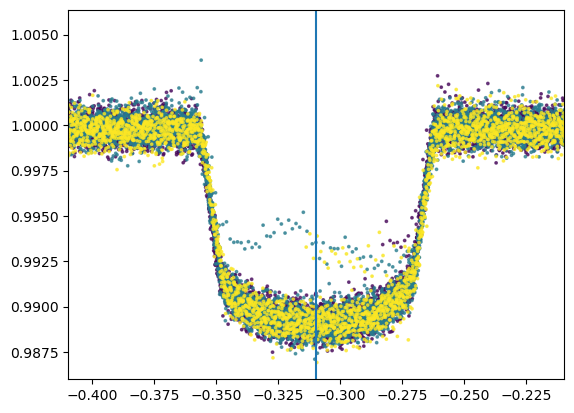

In [112]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# FILL-IN THE eclipse epoch / period, 
period = 0.941452  # 2019AJ Period, table 5 ( table 4 has 1 less decimal point)

t0_primary = 1354.457943  # table 5
t0_secondary = None


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 2.21  # from ExoFOP
duration_hr_secondary = None

t0_for_plotting = 0  # keep 0 for plotting purposes
t0_for_plotting = 0  # keep 0 for plotting purposes
# t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.25  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.1, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.1);
# plt.ylim(0.75, 0.85);
plt.show()

### Now that the data is ready we can start 

In [82]:
# show data to visualize what's changed in each step below
data  

,time,flux,err,phase
0,1354.111507,0.999843,0.000543,0.322408
1,1354.112896,1.000607,0.000543,0.323883
2,1354.114285,0.999661,0.000543,0.325358
3,1354.117063,0.999716,0.000543,0.328309
4,1354.118452,1.000139,0.000543,0.329784
...,...,...,...,...
31158,1406.211581,0.989685,0.000531,-0.337465
31159,1406.212970,0.990258,0.000531,-0.335990
31160,1406.214359,0.989172,0.000531,-0.334514
31161,1406.215748,0.989601,0.000531,-0.333039


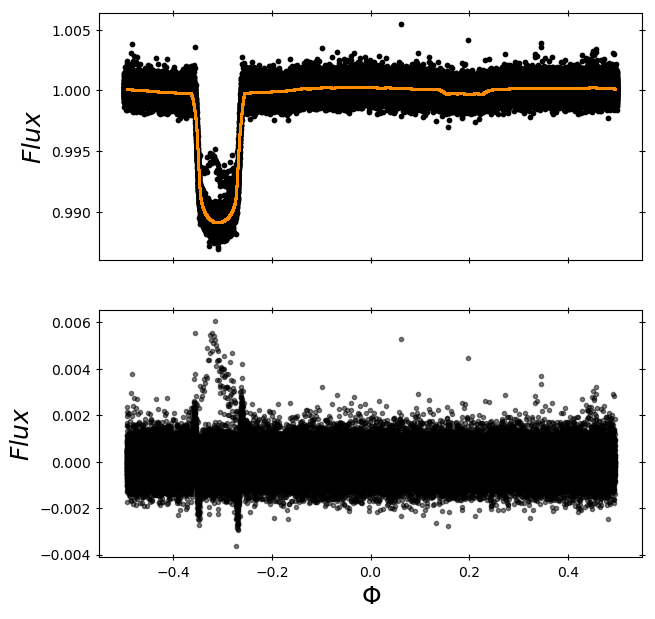

,time,flux,err,phase,flux_sub_binary,binary_model
0,1354.111507,0.999843,0.000543,0.322408,-0.000358,1.000200
1,1354.112896,1.000607,0.000543,0.323883,0.000407,1.000200
2,1354.114285,0.999661,0.000543,0.325358,-0.000539,1.000200
3,1354.117063,0.999716,0.000543,0.328309,-0.000485,1.000201
4,1354.118452,1.000139,0.000543,0.329784,-0.000063,1.000202
...,...,...,...,...,...,...
76757,3206.130505,1.002025,0.000581,-0.483304,0.001947,1.000078
76758,3206.131894,1.002455,0.000581,-0.481829,0.002386,1.000070
76759,3206.133282,1.002816,0.000581,-0.480353,0.002754,1.000062
76760,3206.134671,1.002201,0.000581,-0.478878,0.002147,1.000054


In [113]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

10 75988 901
reached the end
10 75326 901
reached the end
10 75278 901
reached the end
10 75278 901
reached the end


,time,flux,err,phase,flux_sub_binary,binary_model,flux_detrended
0,1354.111507,0.999843,0.000543,0.322408,-0.000358,1.000200,1.000221
1,1354.112896,1.000607,0.000543,0.323883,0.000407,1.000200,1.000983
2,1354.114285,0.999661,0.000543,0.325358,-0.000539,1.000200,1.000037
3,1354.117063,0.999716,0.000543,0.328309,-0.000485,1.000201,1.000090
4,1354.118452,1.000139,0.000543,0.329784,-0.000063,1.000202,1.000511
...,...,...,...,...,...,...,...
76757,3206.130505,1.002025,0.000581,-0.483304,0.001947,1.000078,1.000033
76758,3206.131894,1.002455,0.000581,-0.481829,0.002386,1.000070,1.000444
76759,3206.133282,1.002816,0.000581,-0.480353,0.002754,1.000062,1.000786
76760,3206.134671,1.002201,0.000581,-0.478878,0.002147,1.000054,1.000153


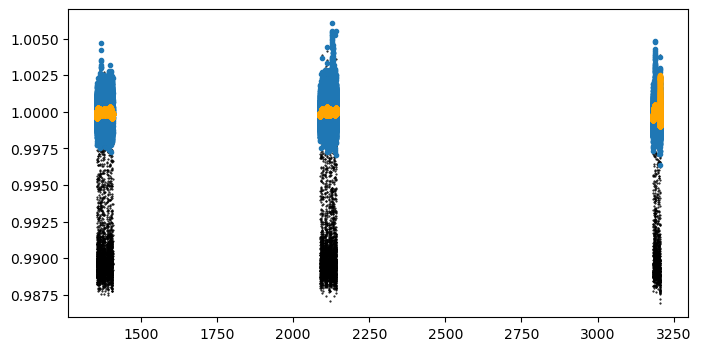

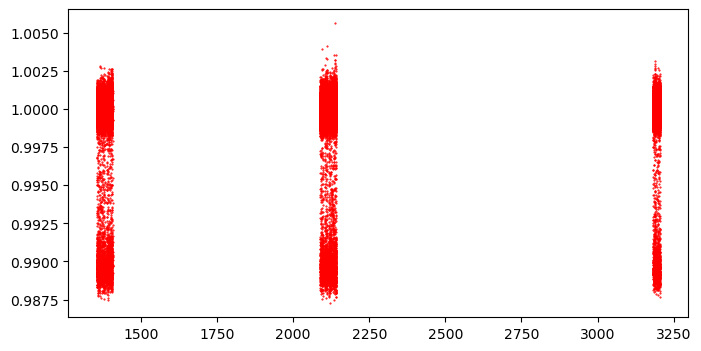

In [114]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

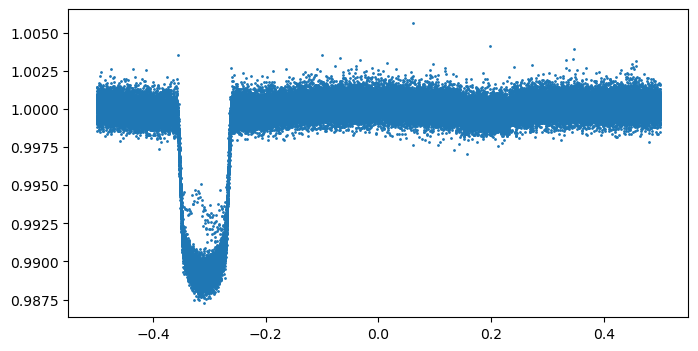

In [115]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1)
plt.show()

Primary:   1354.457943 -0.309612173536264
window_width_p (phase): 0.10759089859776884


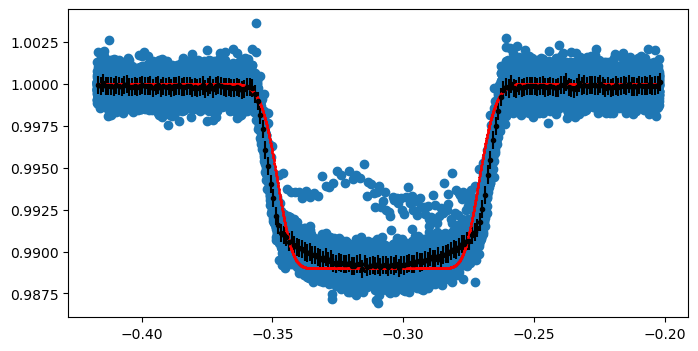

In [116]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.1 * duration_hr_primary / 24 / period
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p) & (data['phase'] < midpoint_p + window_width_p) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)
    
    # window_width_s = 0.9 * duration_hr_secondary / 24 / period
    window_width_s = window_width_p
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s) & (data['phase'] < midpoint_s + window_width_s) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase
start_vals = [1, -0.011, midpoint_p, 0.018, 20.0]
# start_vals_s = [1, -0.018, midpoint_s, 0.0055, 1.017]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [117]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = False

if run_init_fit:
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, plot_chains = False, plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, plot_chains = False, plot = True)
    !$NOTIFY_CMD "Initial fit done"

Use pre-defined inital model params:


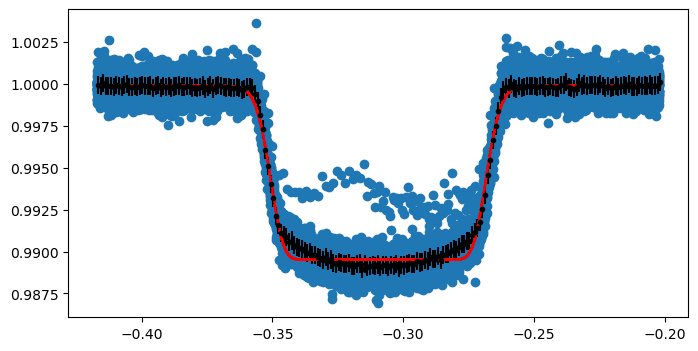

In [118]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data (sectors 2-3) + 2019AJ Period
    # mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9998929694743187, -0.010350229406086138, -0.3844227964260451, 0.018304779457415613, 33.493681231984624  # P=0.94145 (1 less digit)
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9998922865429706, -0.010339735752068736, -0.3097005930581747, 0.018115823405324763, 37.70732176128997  # P=0.941452
    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    if t0_secondary is not None:
        # mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0003898377968548, -0.017223173189843427, -0.32095517717339916, 0.004725213244550472, 1.684847812076929
        etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [119]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 0.9998922865429706, -0.010339735752068736, -0.3097005930581747, 0.018115823405324763, 37.70732176128997


1966

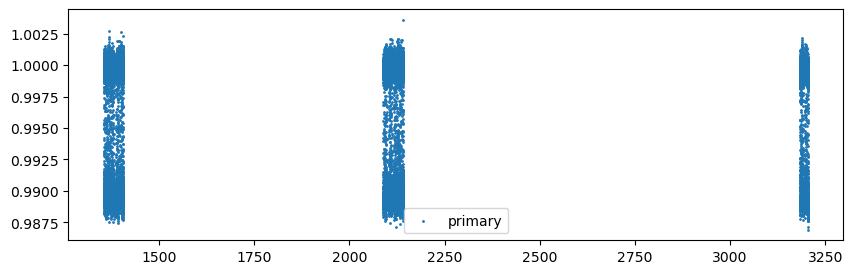

In [120]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1354.457943 0.941452 1354.457943


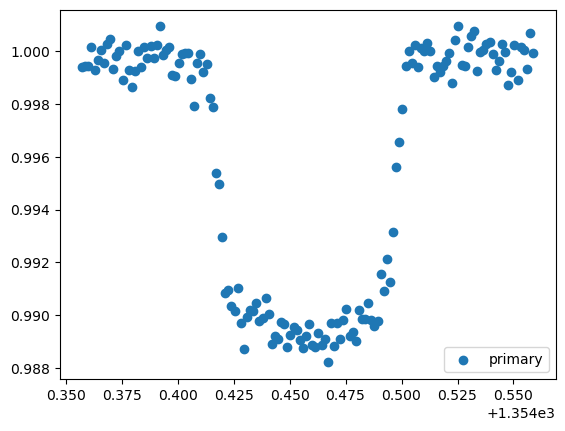

1354.457943 0.941452 1355.399395


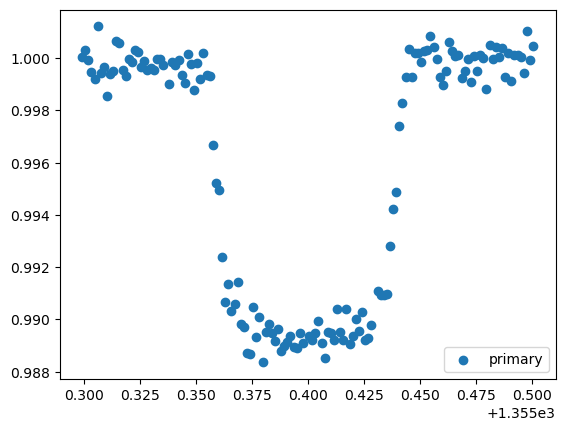

1354.457943 0.941452 1356.340847


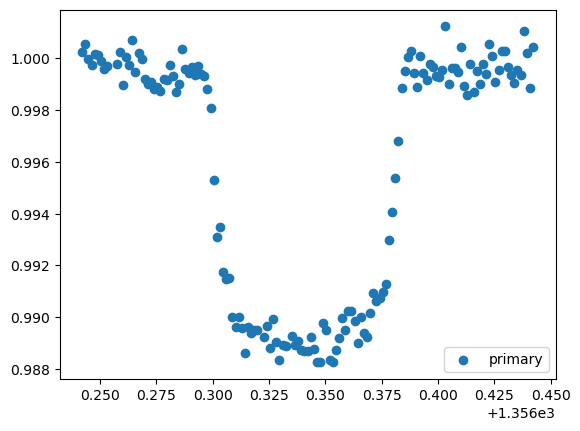

In [121]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
Number 1 has already been completed -- skip
Number 2 has already been completed -- skip
Number 3 has already been completed -- skip
Number 4 has already been completed -- skip
Number 5 has already been completed -- skip
Number 6 has already been completed -- skip
Number 7 has already been completed -- skip
Number 8 has already been completed -- skip
Number 9 has already been completed -- skip
Number 10 has already been completed -- skip
Number 11 has already been completed -- skip
Number 12 has already been completed -- skip
Number 13 has already been completed -- skip
Number 15 has already been completed -- skip
Number 16 has already been completed -- skip
Number 17 has already been completed -- skip
Number 18 has already been completed -- skip
Number 19 has already been completed -- skip
Number 20 has al

100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.46it/s]


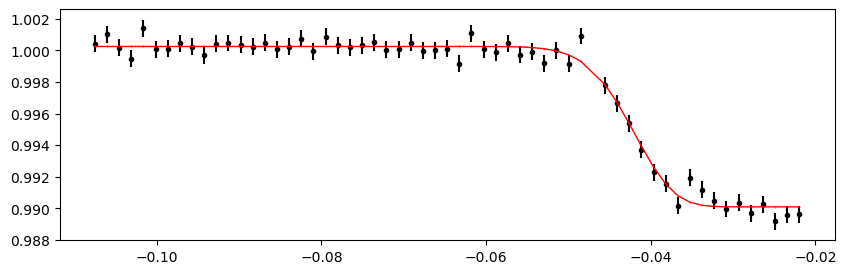

2088.7905029999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.50it/s]


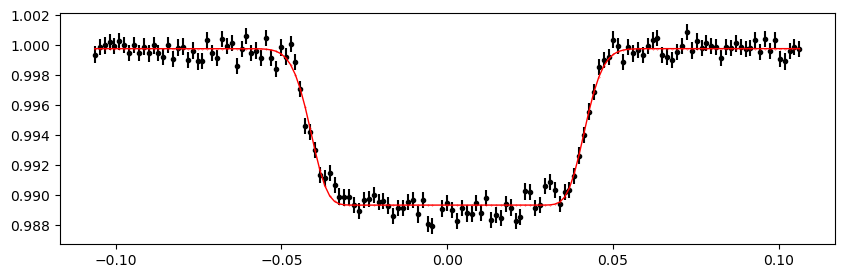

2089.7319549999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.59it/s]


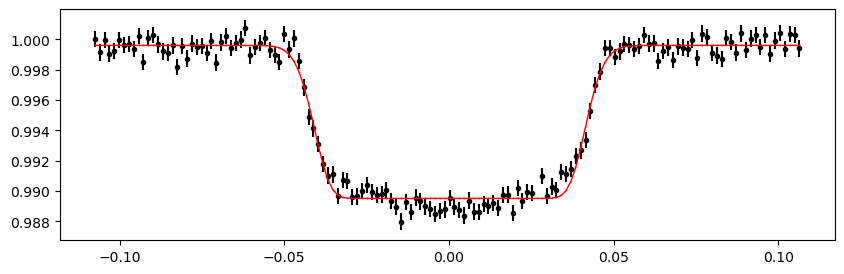

2090.6734069999998 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.75it/s]


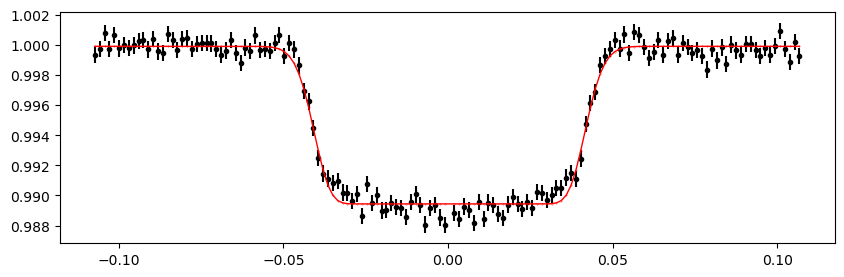

2091.614859 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.37it/s]


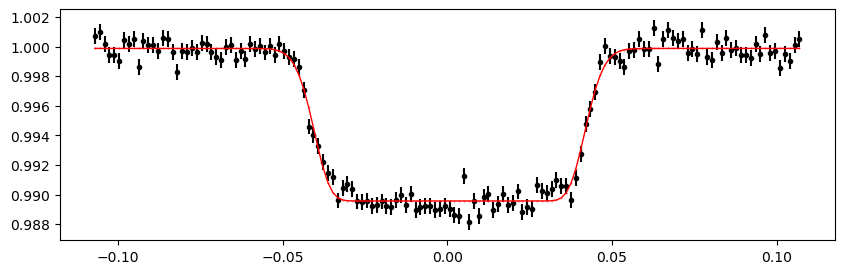

2092.556311 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.28it/s]


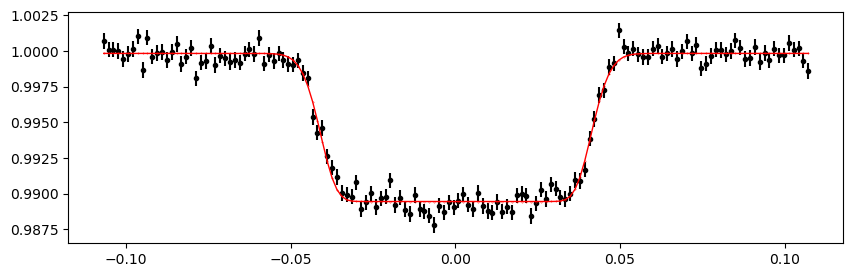

2093.497763 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:37<00:00, 265.55it/s]


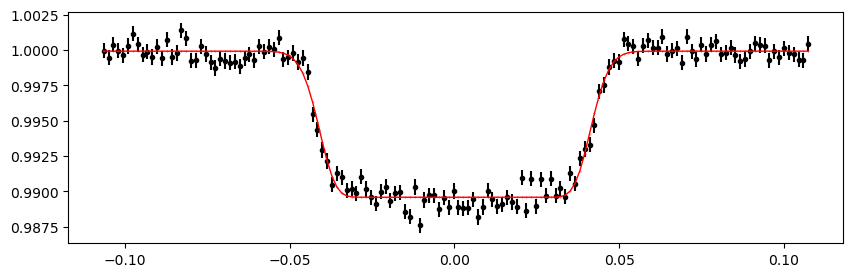

2094.439215 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.48it/s]


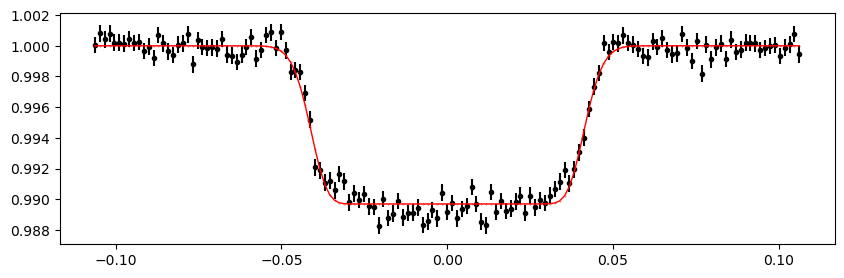

2095.380667 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.53it/s]


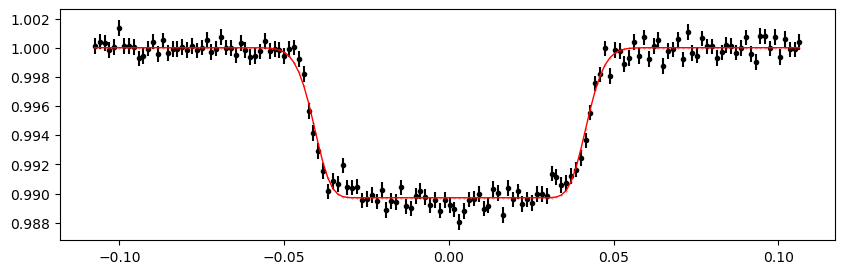

2096.322119 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.77it/s]


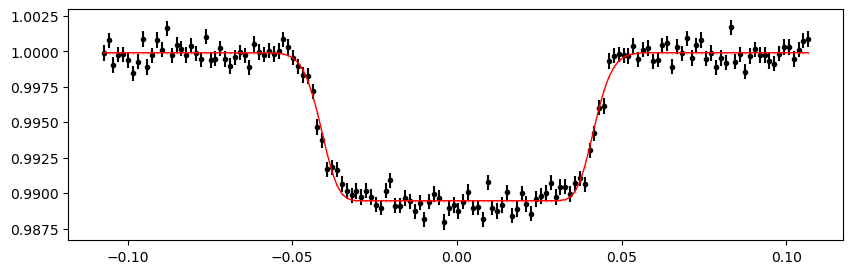

2097.263571 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.46it/s]


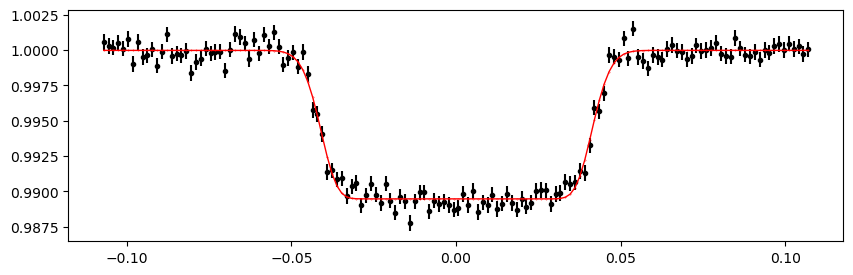

2098.205023 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.87it/s]


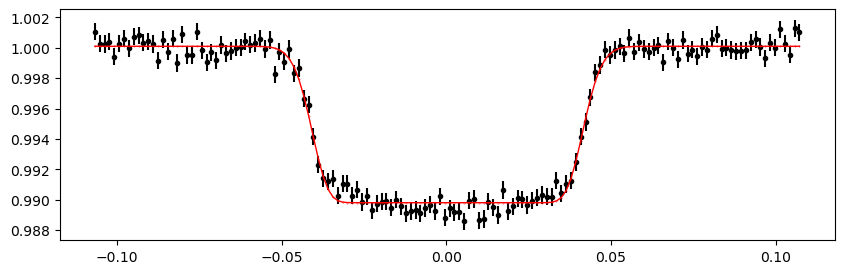

2102.9122829999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.09it/s]


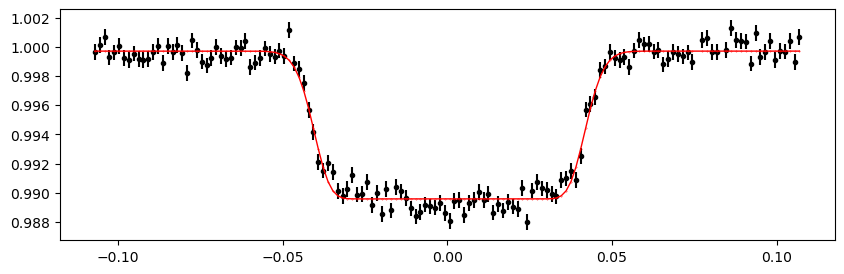

2103.8537349999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 354.35it/s]


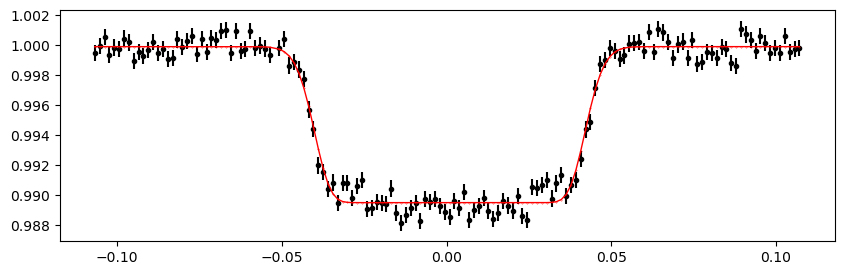

2104.7951869999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 358.04it/s]


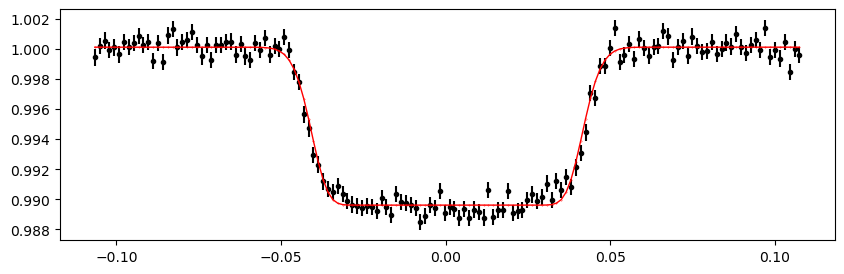

2105.7366389999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.78it/s]


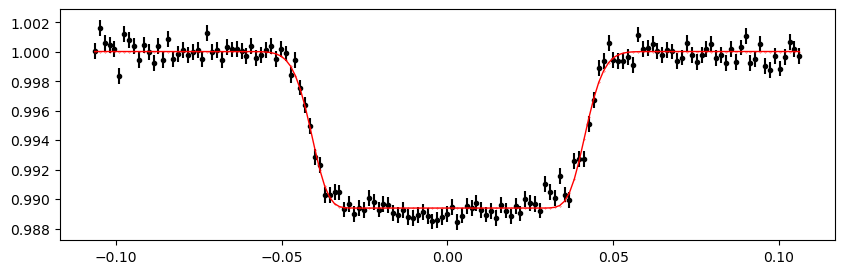

2106.6780909999998 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 355.09it/s]


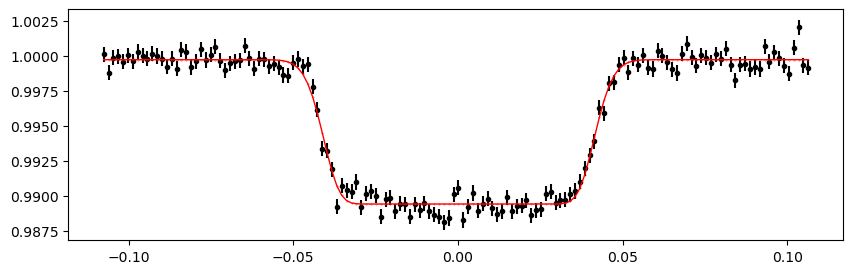

2107.619543 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.45it/s]


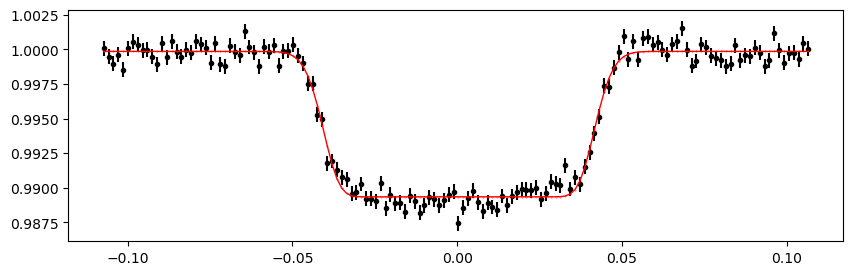

2108.560995 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.09it/s]


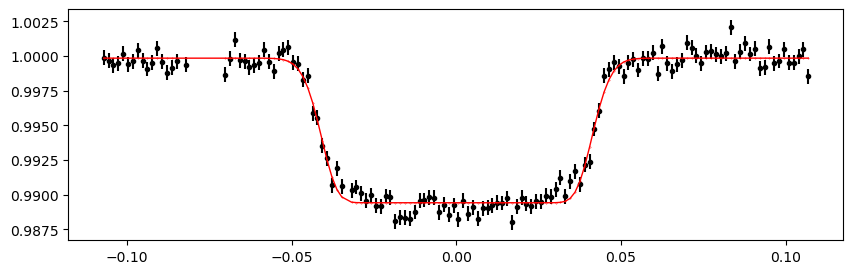

2109.502447 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 348.92it/s]


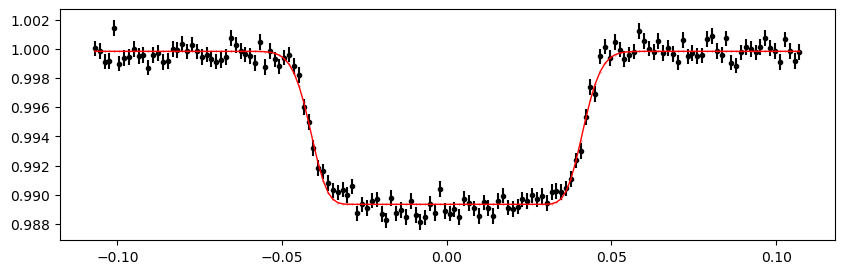

2110.443899 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 353.47it/s]


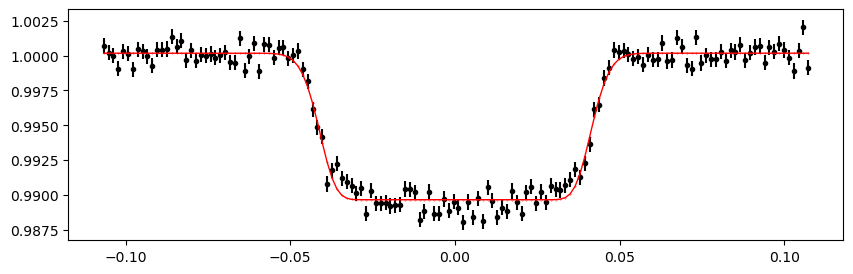

2111.385351 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.81it/s]


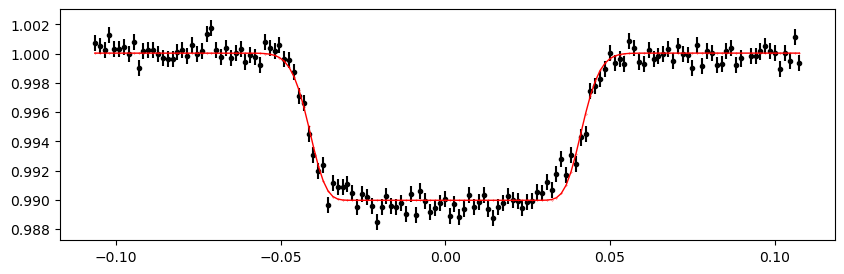

2116.092611 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.23it/s]


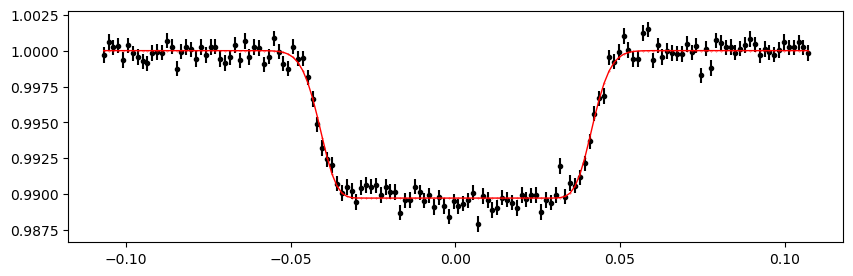

2117.034063 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.45it/s]


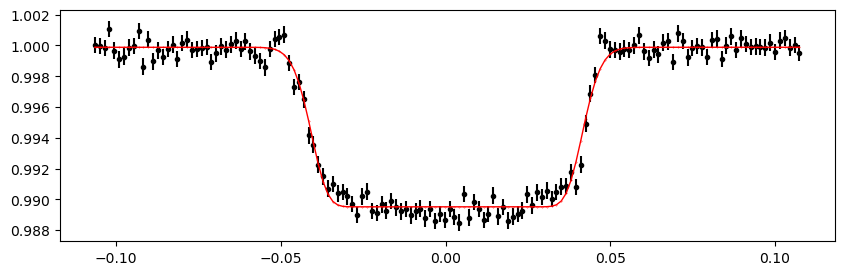

2117.975515 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:41<00:00, 242.82it/s]


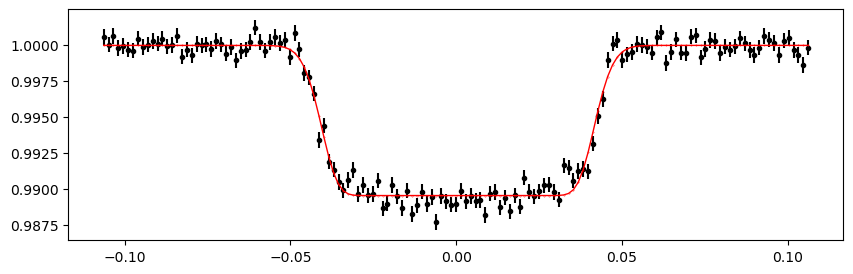

2118.916967 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.12it/s]


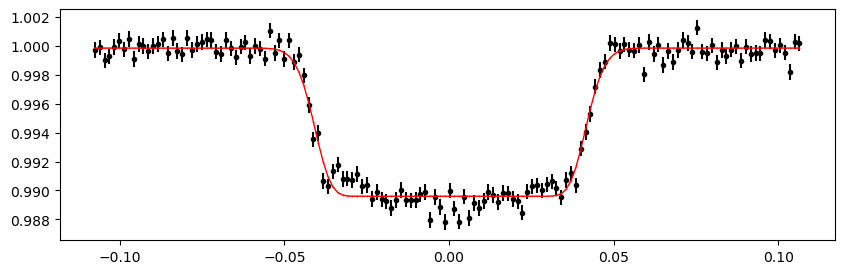

2119.8584189999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.70it/s]


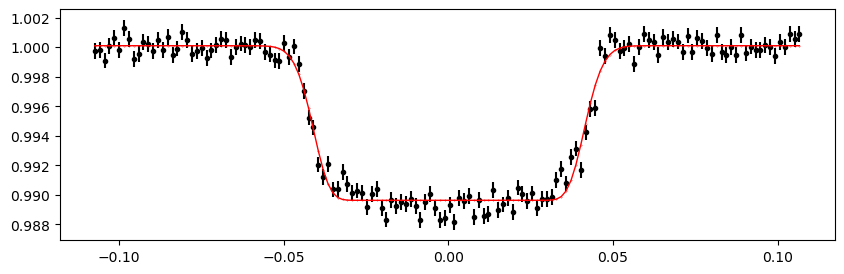

2120.7998709999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.11it/s]


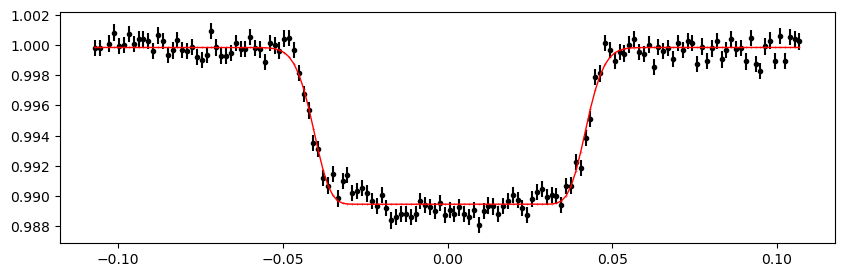

2121.7413229999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.66it/s]


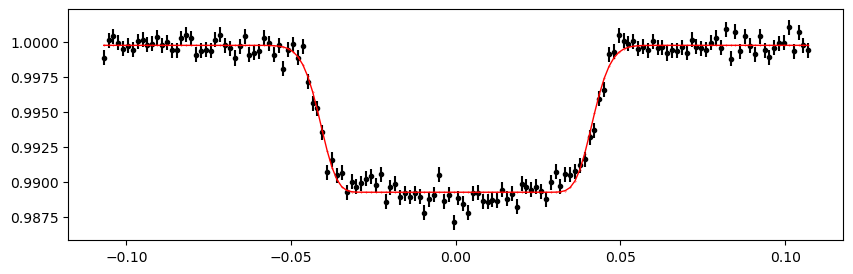

2122.6827749999998 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.11it/s]


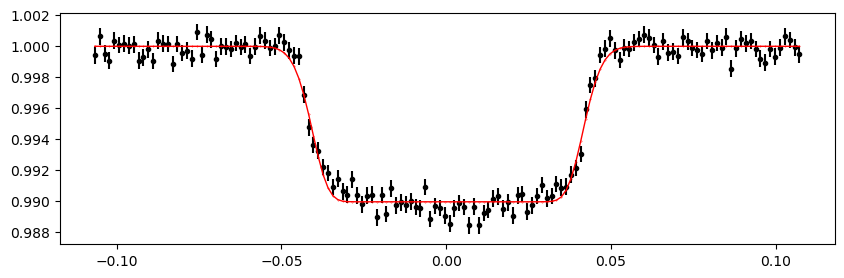

2123.624227 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.68it/s]


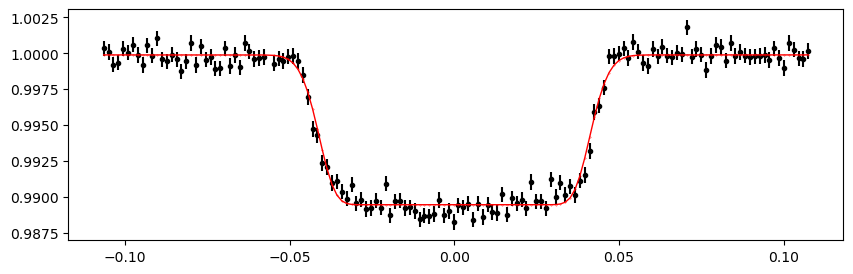

2124.565679 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.55it/s]


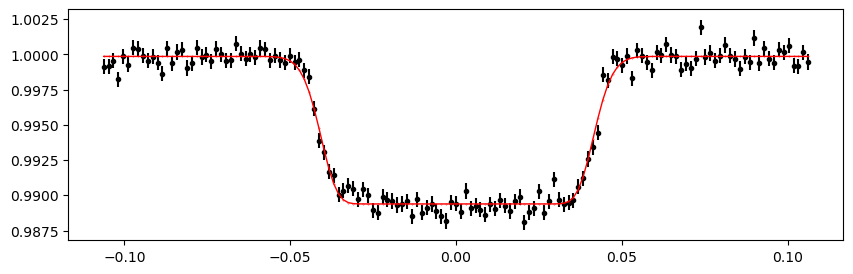

2125.507131 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.37it/s]


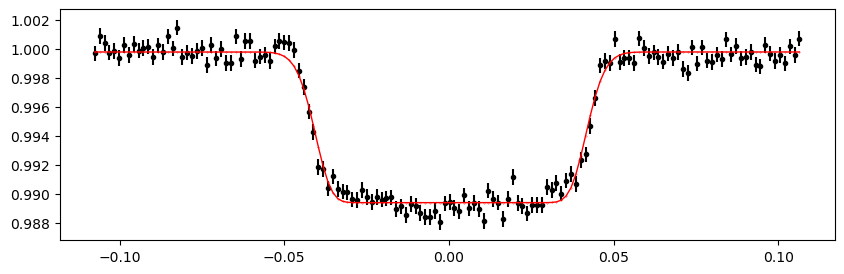

2126.448583 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.91it/s]


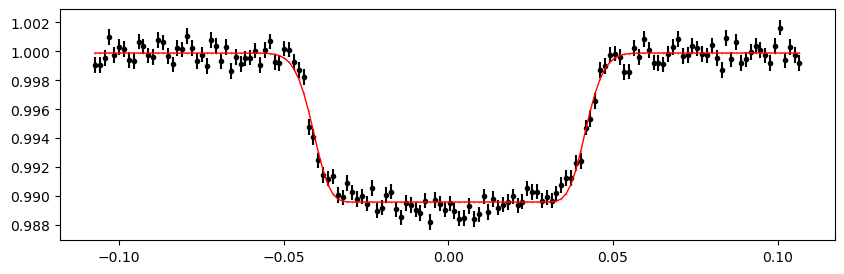

2127.390035 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.92it/s]


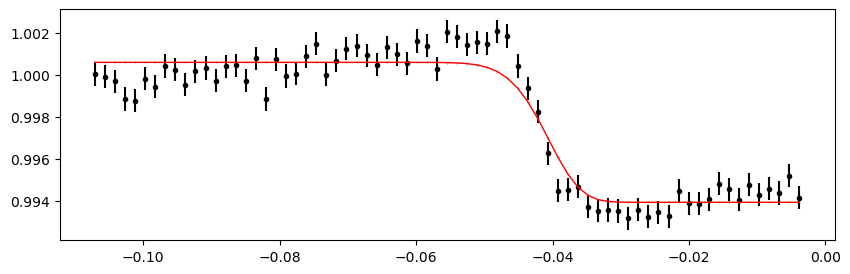

2130.214391 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.67it/s]


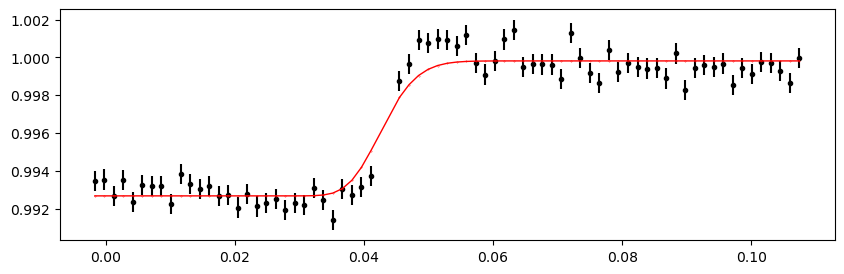

2131.155843 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.57it/s]


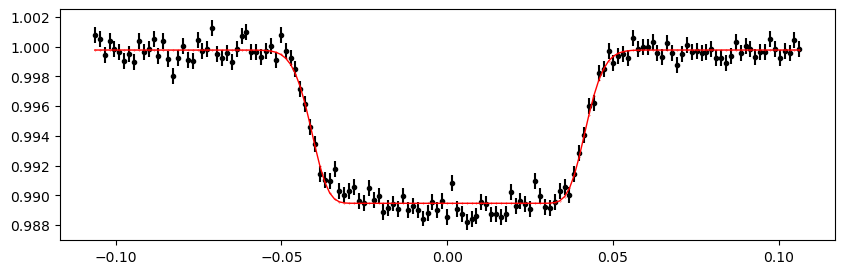

2132.0972949999996 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.09it/s]


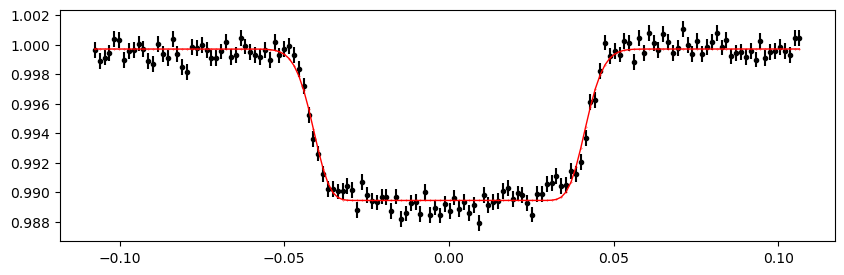

2133.0387469999996 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 344.98it/s]


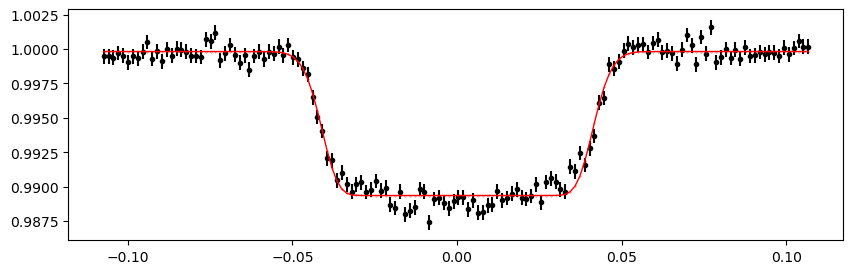

2133.9801989999996 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 347.28it/s]


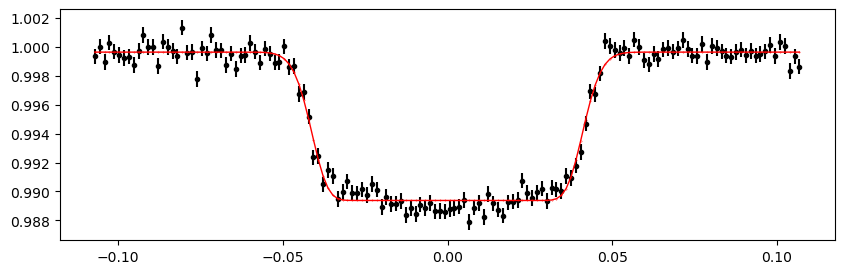

2134.9216509999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.41it/s]


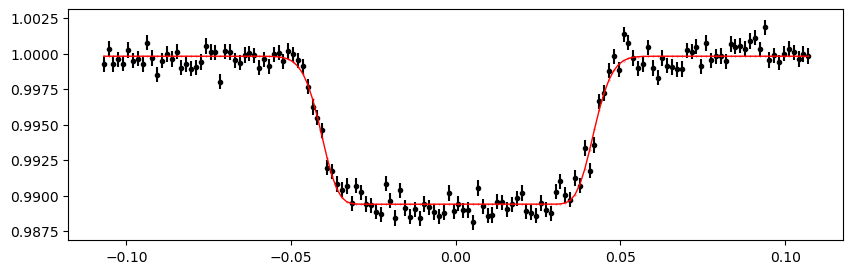

2135.8631029999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.99it/s]


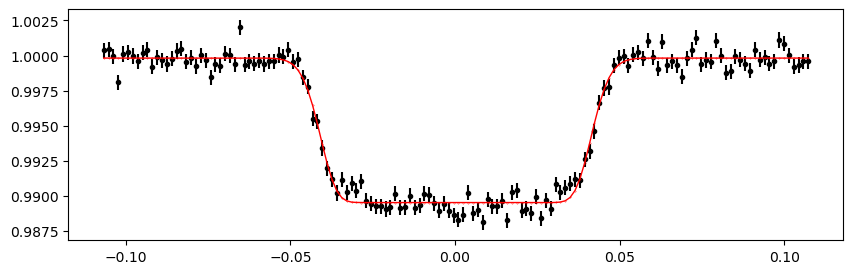

2136.8045549999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.78it/s]


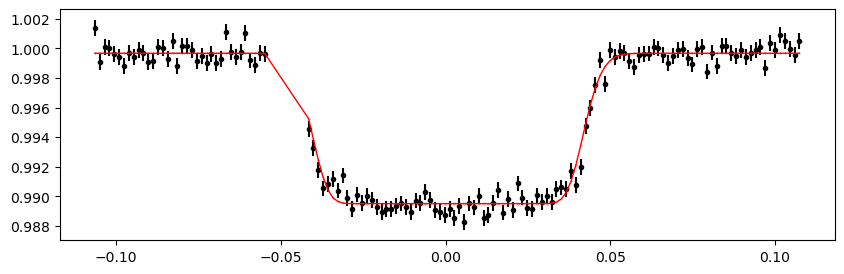

2137.7460069999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.69it/s]


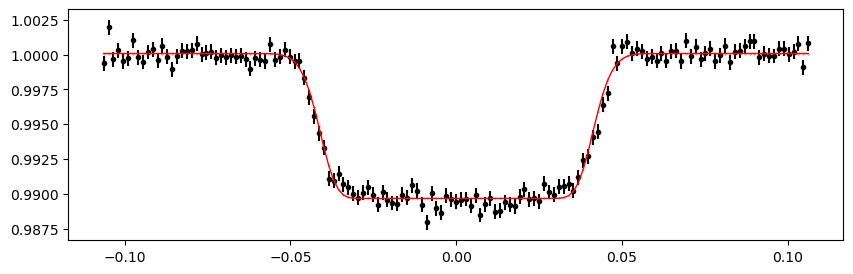

2138.6874589999998 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 339.50it/s]


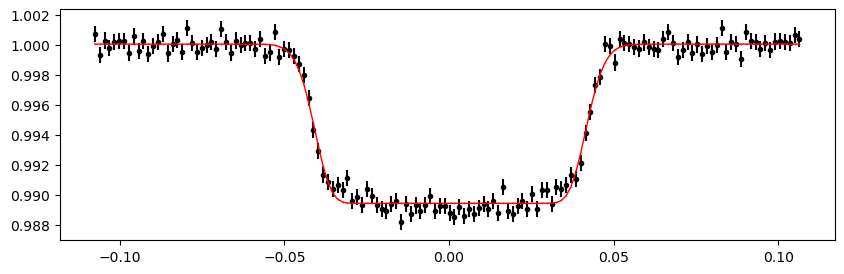

2139.628911 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 341.04it/s]


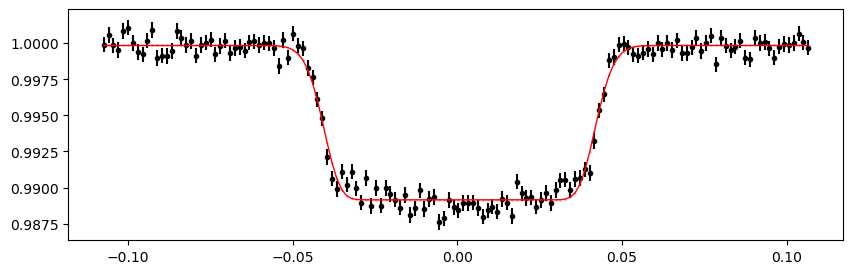

2140.570363 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.76it/s]


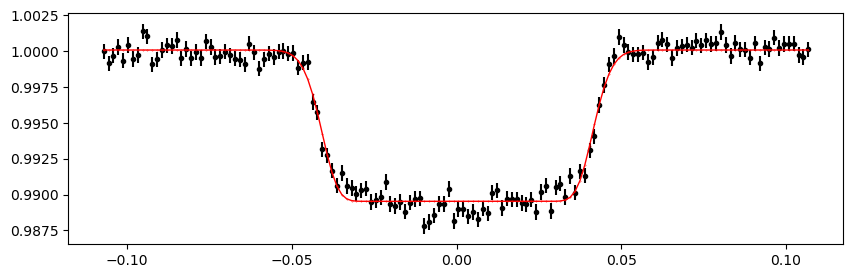

2141.511815 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.15it/s]


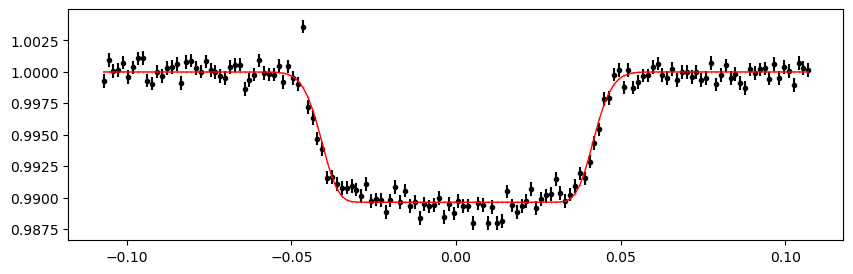

3182.7577269999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.60it/s]


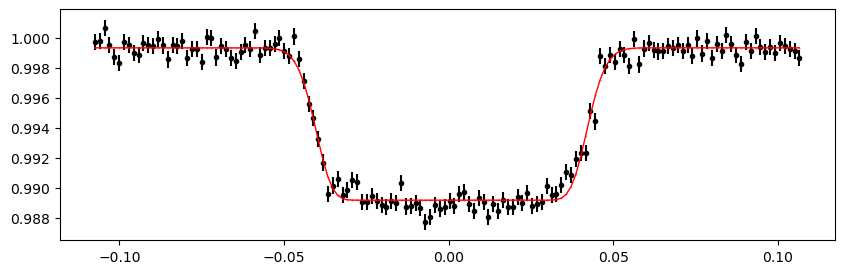

3183.6991789999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 394.20it/s]


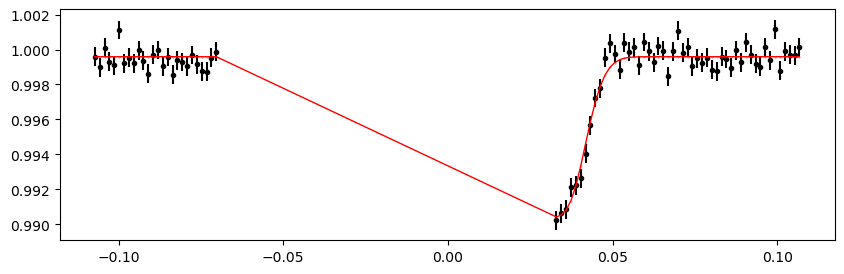

3184.6406309999998 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.31it/s]


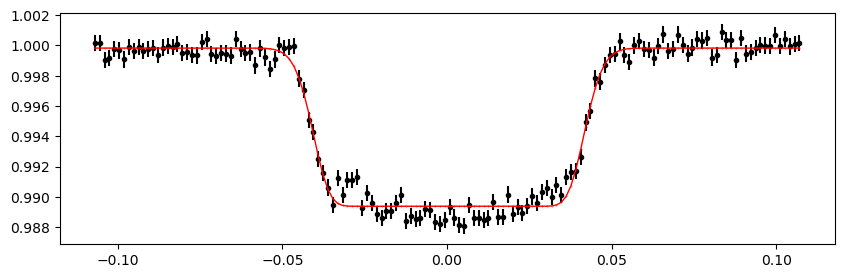

3185.582083 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.13it/s]


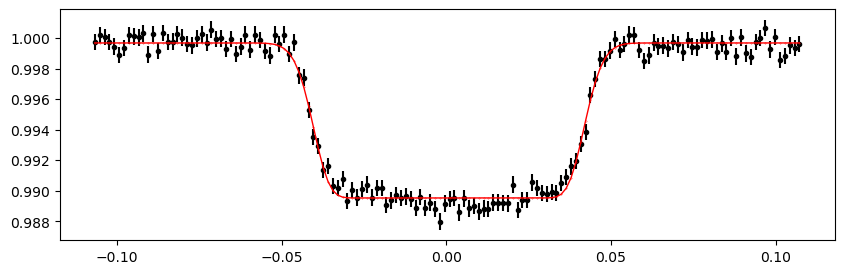

3186.523535 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.25it/s]


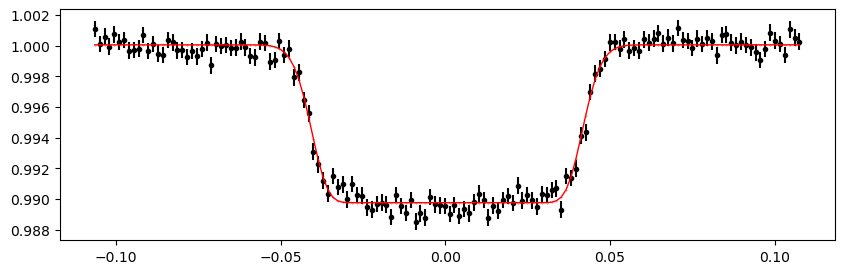

3187.464987 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 346.31it/s]


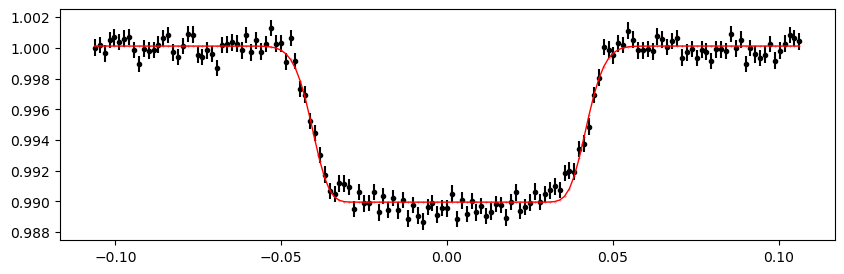

3188.406439 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:25<00:00, 389.54it/s]


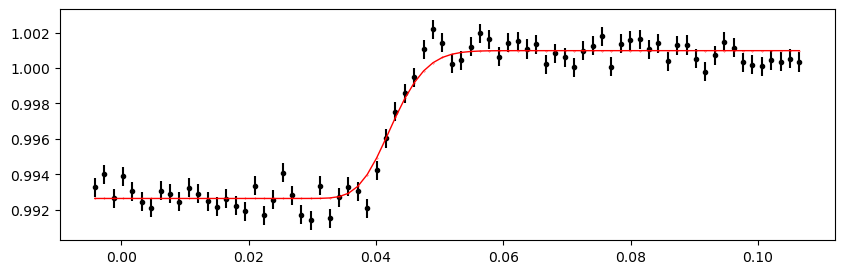

3189.347891 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.24it/s]


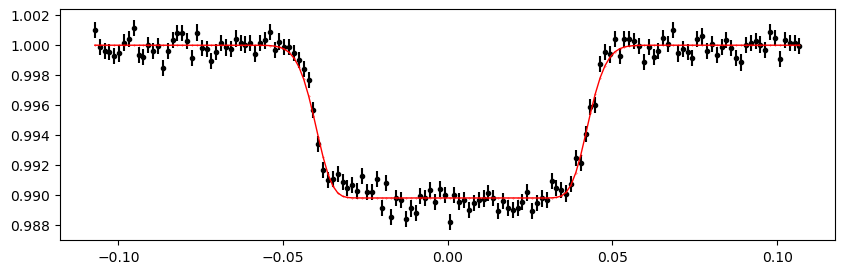

3190.2893429999995 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.96it/s]


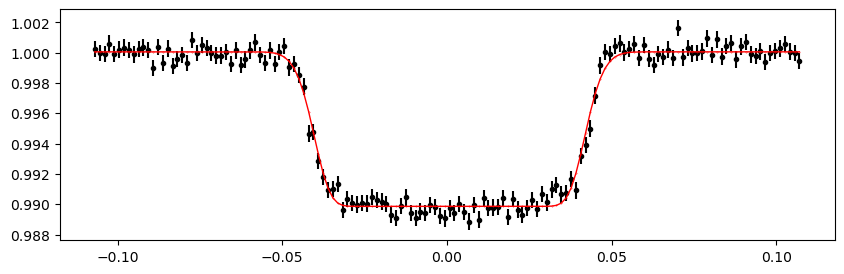

3191.2307949999995 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.06it/s]


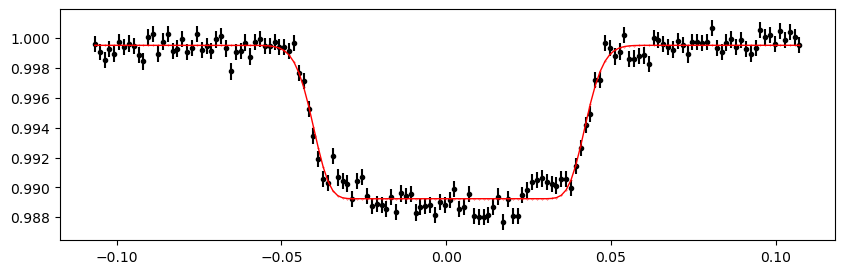

3192.1722469999995 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.31it/s]


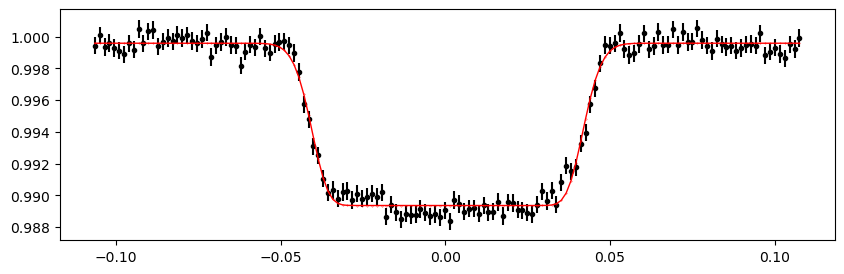

3195.9380549999996 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 344.98it/s]


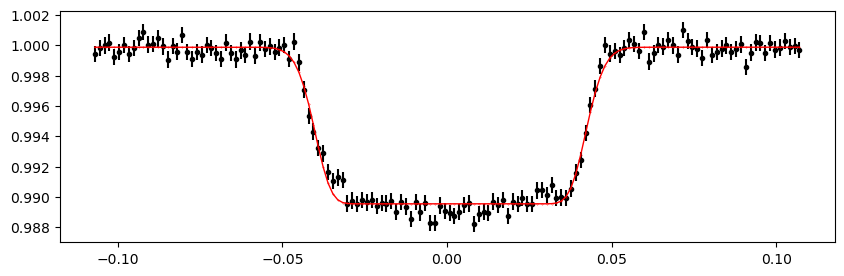

3196.8795069999996 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 344.96it/s]


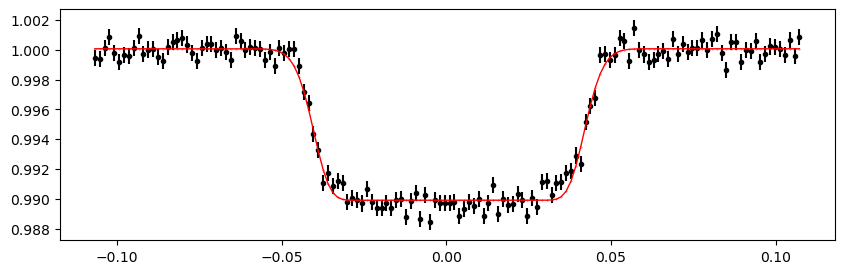

3197.8209589999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 344.34it/s]


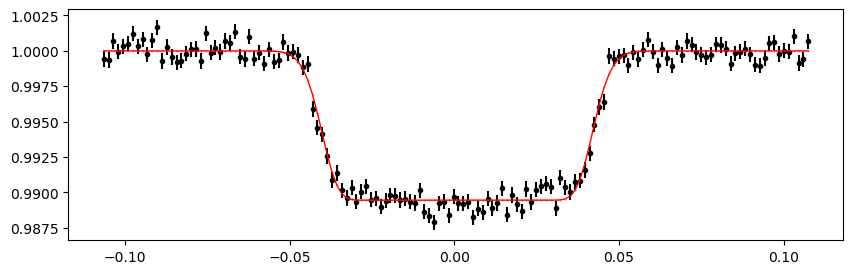

3198.7624109999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.59it/s]


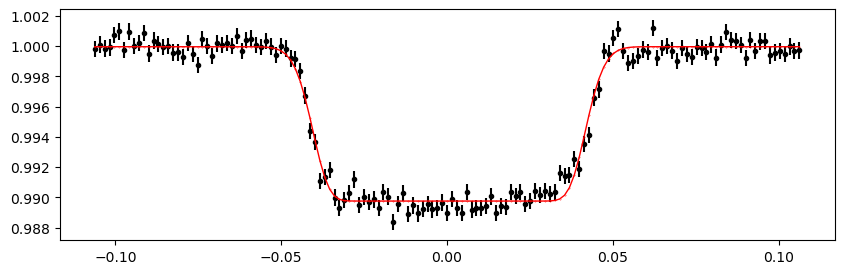

3199.7038629999997 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.63it/s]


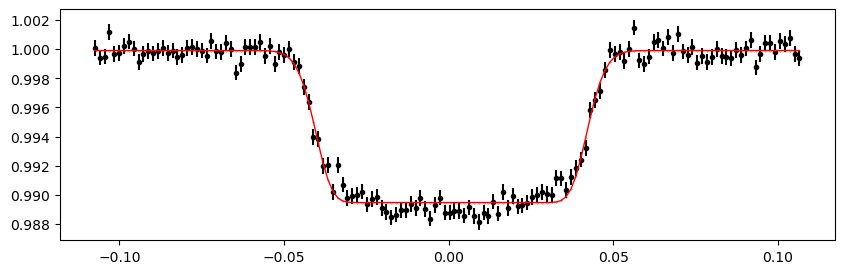

3200.6453149999998 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.92it/s]


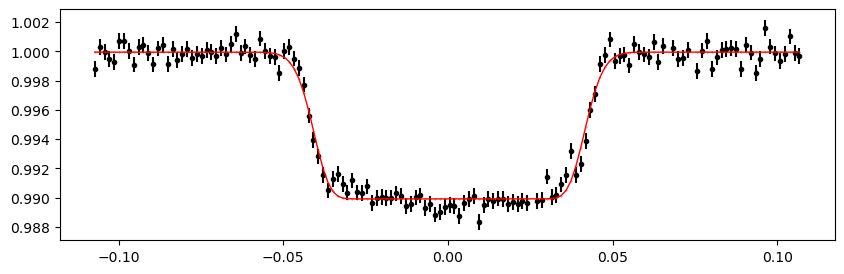

3201.586767 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 501.18it/s]


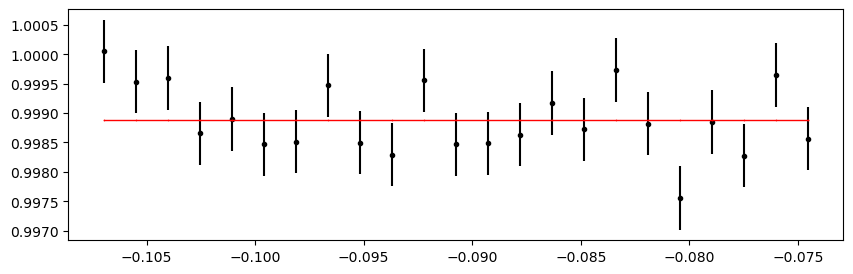

3202.528219 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.84it/s]


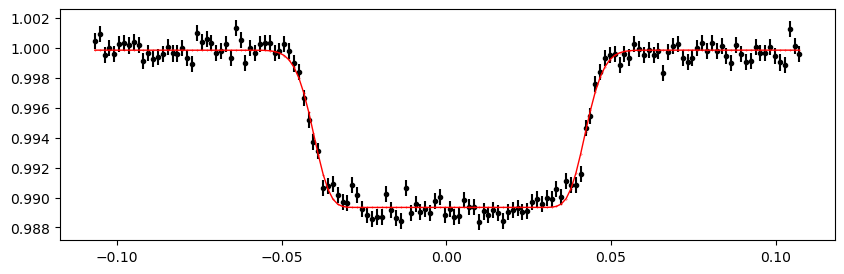

3203.469671 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.03it/s]


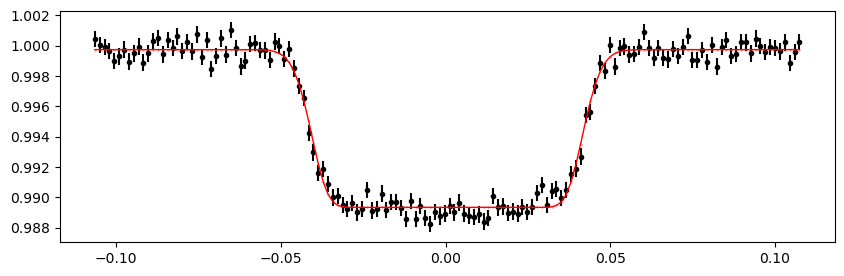

3204.411123 0.9998922865429706 -0.010339735752068736 -0.3097005930581747


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 343.81it/s]


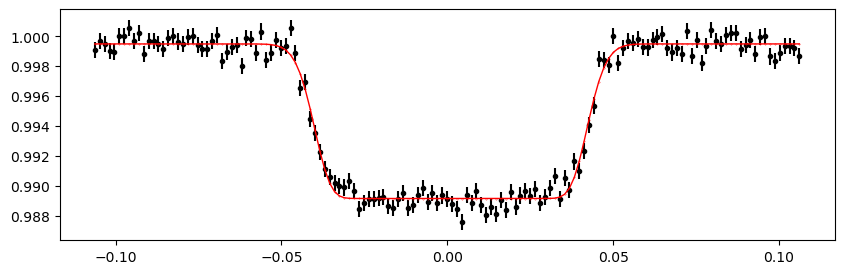

In [122]:
%matplotlib inline

from importlib import reload
reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=12,  # Kepler 30-min cadene data requires a lower min_number_data
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

In [98]:
%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=12,  # Kepler 30-min cadene data requires a lower min_number_data
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")

No secondary eclipses defined. No-Op.


## ETV O-C plot

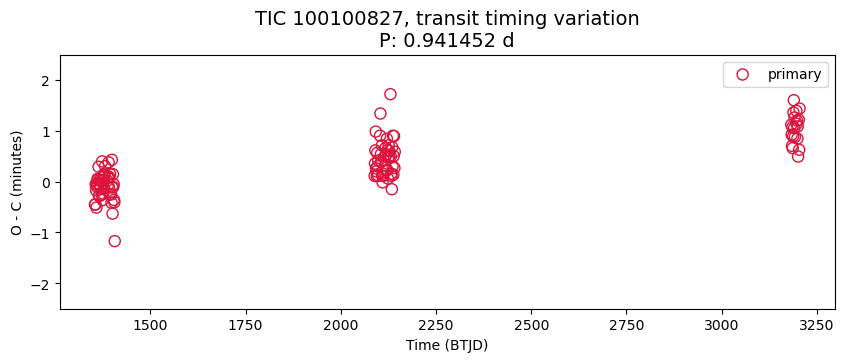

In [130]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60


axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
# axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
#              lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    # axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
    #              lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, transit timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.ylim(-2.5, 2.5)
plt.show()

### O-C Plot, Zoom In

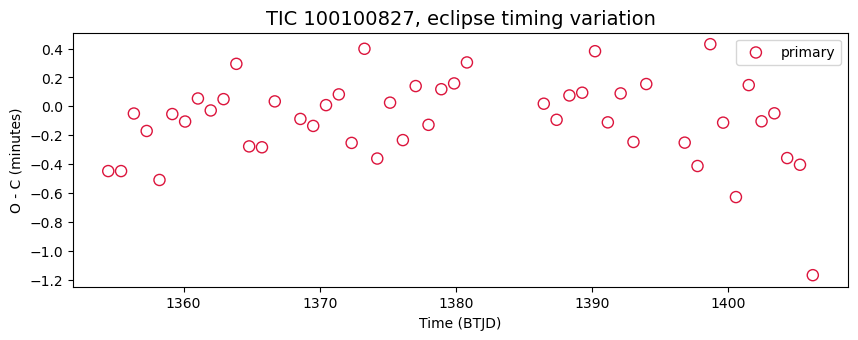

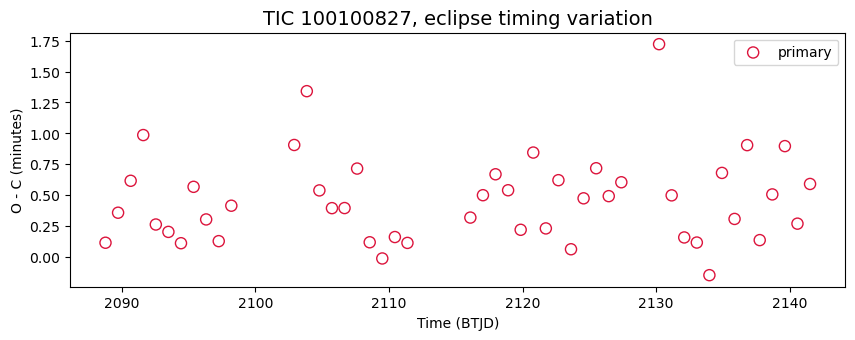

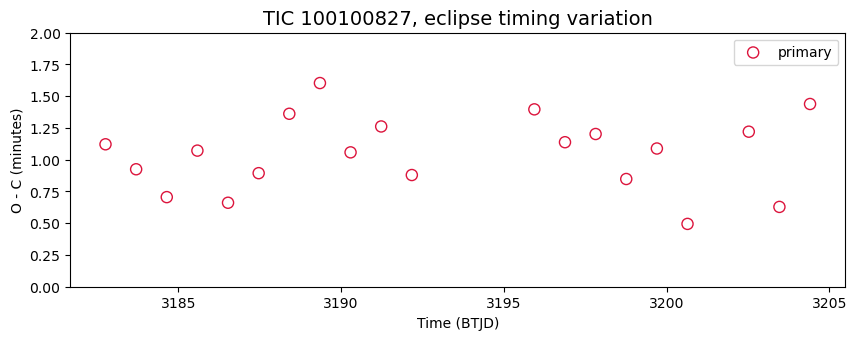

In [138]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5


# First chunk
#
zoom_start, zoom_end = 1300, 1500

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


#
# Second chunk
#
zoom_start, zoom_end = 2000, 2300

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)

plt.subplots_adjust(hspace=0.05)
plt.show()


#
# Third chunk
#
zoom_start, zoom_end = 3100, 3300

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60
in_df_primary = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]

axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
             marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")

if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    in_df_secondary = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]

    axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
                 marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel("Time (BTJD)")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation", fontsize=14)
axs[0].set_ylim(0, 2)  # custom zoom 

plt.subplots_adjust(hspace=0.05)
plt.show()



## make a periodogram 

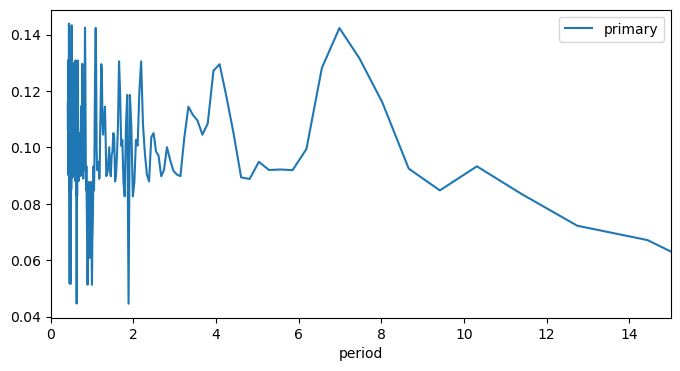

In [141]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 15)
plt.show()


## Results Summary

In [143]:
# FILL-IN the ETV results / comments
has_etv = "Practice"  # FP, not only it has no ETV, there is no evidence that the orbital period is significantly different from SB period
comments = "Reproducing TESS TTV in 2019J: works"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

,0
tic,100100827
has_etv,Practice
comments,Reproducing Kepler TTV in 2019J works: somewhat works
period,0.941452
depth_pct_p,1.03
depth_pct_s,None
epoch_p,1354.457943
epoch_s,None
num_sectors,5
time_span,1854.03



tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
100100827,Practice,Reproducing Kepler TTV in 2019J works: somewhat works,0.941452,1.03,,1354.457943,,5,1854.03,1354.11,3208.14

